<a href="https://colab.research.google.com/github/ckevar/Conv4MammographyAbnormalities/blob/main/Scratch_CNN_4classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Mounting Drive
In this Notebook, the design of 4-class classifier is built from scratch, such classes are:

**Benign Mass**, **Malignant Mass**, **Benign Calcification**, **Malignant Calcification**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import requests

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import output
from google.colab import drive

# Mounting Drive
drive.mount("/content/gdrive")
base_path = "/content/gdrive/My Drive/CI_proj/"
metrics_path = base_path+"metrics/"

Mounted at /content/gdrive


# Loading Data
the followind data is for training only

In [ ]:
img = np.load(base_path+'dataset/train_tensor.npy') 
labels = np.load(base_path+'dataset/train_labels.npy') 
depth, width, height = img.shape # shape of the train label depth_val, width_val, height_val = images_val.shape # shape of the train label
classLabel = ["Mass", "Calcification"]

## Data Processing
the approach for this classifier will be by categories organized over a vector (one hot encoding) as follows:

[Benign Mass, Malignant Mass, Bening Calcification, Malignant Calcification]

In [ ]:
labels_train = np.array([]);
idx = [];

# Extracting Abnormalities from data set, and vectorizing the training labels
for i in range(depth):

  if (labels[i] == 1):    # Mass, Benign
    idx.append(i)
    labels_train = np.append(labels_train, [1., 0., 0., 0.])

  elif (labels[i] == 2):  # Mass, Malignant
    idx.append(i)
    labels_train = np.append(labels_train, [0., 1., 0., 0.])

  elif (labels[i] == 3):  # Calcification, Benign
    idx.append(i)
    labels_train = np.append(labels_train, [0., 0., 1., 0.])

  elif (labels[i] == 4):  # Calcification, Malignant
    idx.append(i)
    labels_train = np.append(labels_train, [0., 0., 0., 1.])

# Filter abnormalities from full image set
img = img[idx];
depth = idx.__len__()
labels_train = labels_train.reshape(depth, 4)

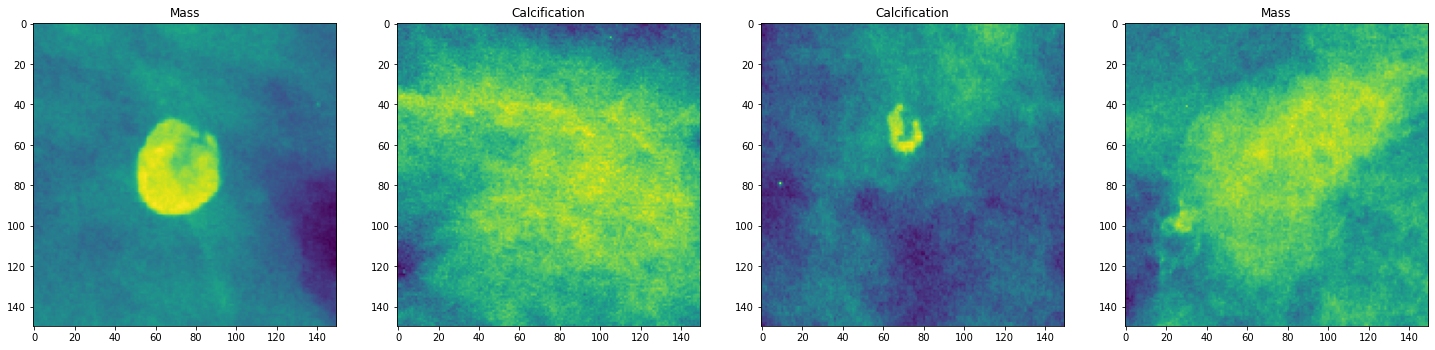

In [ ]:
toPlot = np.random.randint(depth, size = 4)

plt.figure(figsize=(25, 10))
for x in range(toPlot.__len__()):
  plt.subplot(1, 4, x + 1)
  plt.imshow(img[toPlot[x]])
  plt.title(classLabel[np.int_(labels_train[toPlot[x]])])

# Normalization
The input has to be normalized to feed the neural network

In [ ]:
img = img.reshape((depth, width, height, 1))
img = img.astype('float32') / 65535;

# Helper Functions
Functions for training and plotting are implemented

In [ ]:
def trainModel_w_kFold(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implements k-fold algorithm
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # metrics vector
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # model
  model.compile(optimizer = optmz, loss="categorical_crossentropy", metrics = ['accuracy'])
  model.save_weights(base_path+'Scratch2_2_0.h5')

  # Area under the validation accuracy
  val_acc_int = 0.0  

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    # k-fold algorithm
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)

    model.load_weights(base_path+'Scratch2_2_0.h5');
    # Training
    h = model.fit(img[train], labels_train[train], epochs=epoch, batch_size=batch_size, validation_data=(img[valid], labels_train[valid]), verbose=0)

    # Log metrics
    val_acc_0 = h.history['val_accuracy'];
    acc.append(h.history['accuracy'])
    loss.append(h.history['loss'])
    val_acc.append(val_acc_0)
    val_loss.append(h.history['val_loss'])

    print('=> acc:',acc[-1][-1], 'loss:',loss[-1][-1], 'val_acc:',val_acc[-1][-1], 'val_loss:',val_loss[-1][-1])
    print('DONE------------------------------------------------------------------------------------------')
    reset_weights(model)

    # Area under the validation accuracy
    val_acc_int += np.sum(val_acc_0, axis=0);
    
    print('Area Below Accuracy is ' , val_acc_int / (fold + 1.0))    

  # averaging metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)
  
  return acc, loss, val_acc, val_loss

def reset_weights(md):
  # to release memory or clean the tensor, possible depricateed by google.
  session = backend.get_session()
  for layer in md.layers:
      backend.clear_session()

def trainerNtimes(n_times, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # calls the k-fold algorithm many times

  # Metrics
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Notifies a training has started
  BotNotifier("Starting Scratch22 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # Model and optimizer are created
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # calls k-foldl algorithm
    a, b, c, d = trainModel_w_kFold(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # release memory
    del model
    del adam

    # Log metrics
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)

  # average metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName, np.stack((acc, loss, val_acc, val_loss)))

  # Notifies, training is done
  BotNotifier("Done on Scratch22 with " + str(arg))
  return acc, loss, val_acc, val_loss

def loadResultMetrics(fileName):
  # load metrics from a file
  a = np.load(fileName)
  return a[0], a[1], a[2], a[3]

def BotNotifier(message):
  # Sends message of telegram bot
    TOKEN = "995731858:AAHrY8FYsa0sE6zKkRGtkZgdLo7-VDjvORo"
    CHAT_ID = "597192342"
    URL = "https://api.telegram.org/bot{}/".format(TOKEN)
    url = URL + "sendMessage?text={}&chat_id={}".format(message, CHAT_ID)
    response = requests.get(url)

def PlotFiles(arg):
  # Plot n = size(arg) metric files
  plt.figure(figsize=(25, 8))

  acc = []
  loss = []
  val_acc = []
  val_loss = []

  for files in arg:
    if files is not None:
      acc, loss, val_acc, val_loss = loadResultMetrics(os.path.join(metrics_path, files))
      plt.subplot(1, 2, 1)
      plt.plot(acc, label = 'Train ' + files)
      plt.plot(val_acc, label = 'Val acc ' + files)
      plt.subplot(1, 2, 2)
      plt.plot(loss, label="Training loss " + files)
      plt.plot(val_loss, label="Val loss " + files)

  plt.subplot(1, 2, 1)
  plt.grid()
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.grid()
  plt.legend()

def trainModel_w_kFold_n_generator(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implements k-fold with augmented data


  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # Metrics vectors
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Generators
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     zoom_range=0.2)

  valid_datagen = ImageDataGenerator(rescale=1.)

  # Model
  model.compile(optimizer = optmz, loss="categorical_crossentropy", metrics = ['accuracy'])
  model.save_weights(base_path+'task22_scratch.h5')

  # Area under the validation accuracy curve
  val_acc_int = 0.0  

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # k-fold
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # generators
    train_generator = train_datagen.flow(img[train], labels_train[train], batch_size=batch_size)
    valid_generator = valid_datagen.flow(img[valid], labels_train[valid])

    model.load_weights(base_path+'task22_scratch.h5')

    # Train
    h = model.fit(train_generator, 
                            steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
                            epochs=epoch, 
                            validation_data=valid_generator, 
                            validation_steps=np.ceil(valid.shape[0]/batch_size), 
                            verbose=0)    
    
    # Log metrics
    val_acc_0 = h.history['val_accuracy'];
    acc.append(h.history['accuracy'])
    loss.append(h.history['loss'])
    val_acc.append(val_acc_0)
    val_loss.append(h.history['val_loss'])

    print('=> acc:',acc[-1][-1], 'loss:',loss[-1][-1], 'val_acc:',val_acc[-1][-1], 'val_loss:',val_loss[-1][-1])
    print('DONE------------------------------------------------------------------------------------------')
    reset_weights(model)

    val_acc_int += np.sum(val_acc_0, axis=0);
    
    print('Area Below Accuracy is ' , val_acc_int / (fold + 1.0))
  
  # Average metrics  
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  return acc, loss, val_acc, val_loss, val_acc_int/5.0

def trainerNtimes_generator_saveInitModel(n_times, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # Runs the k-fold with augmented data n_times

  # Metric vectors
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Notifies, a training has started
  BotNotifier("Starting Scratch22 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # optimizer and model creation
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # Call k-fold algorithm
    a, b, c, d, aba = trainModel_w_kFold_n_generator(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # release memory
    del model
    del adam

    # log metrics
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)

  # average metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName + ".npy", np.stack((acc, loss, val_acc, val_loss)))

  # Notify, training is done
  BotNotifier("Done on Scratch22 with " + str(arg) + " ABA: " + str(aba));
  return acc, loss, val_acc, val_loss

# General Parameters

In [ ]:
k = 5;      # this represents the 20 % of data set provided
EPOCH = 30  # Epochs per training
BATCH = 32  # Size of the batch
learning_rate = 0.00007 # Learning Rate
save_model = True       # variable to enable/disable the saving of generated model
times2run_trainer = 1   # Times the trainer will run on the same (the model restarts between trainings)

#Second Model Categorical
Giving the good performance of these model in the previous task. This is the attempt of using it for this problem as well. the last layer has been changed by a 4-neuron layer with softmax activation for categorical classification.

In [ ]:
def genSecondModel_categorical(arg):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(40, (3, 3), activation='relu', input_shape=(width, height, 1), padding='same', strides=2))
  model.add(layers.BatchNormalization())  
  model.add(layers.MaxPooling2D(2, padding='same'))
  
  model.add(layers.Conv2D(160, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2))
  
  model.add(layers.Conv2D(640, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, padding='same'))

  model.add(layers.Conv2D(640*4, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2, padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(75, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.summary()
  return model  

##Training

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 40)        400       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 160)       57760     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 640)       922240    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


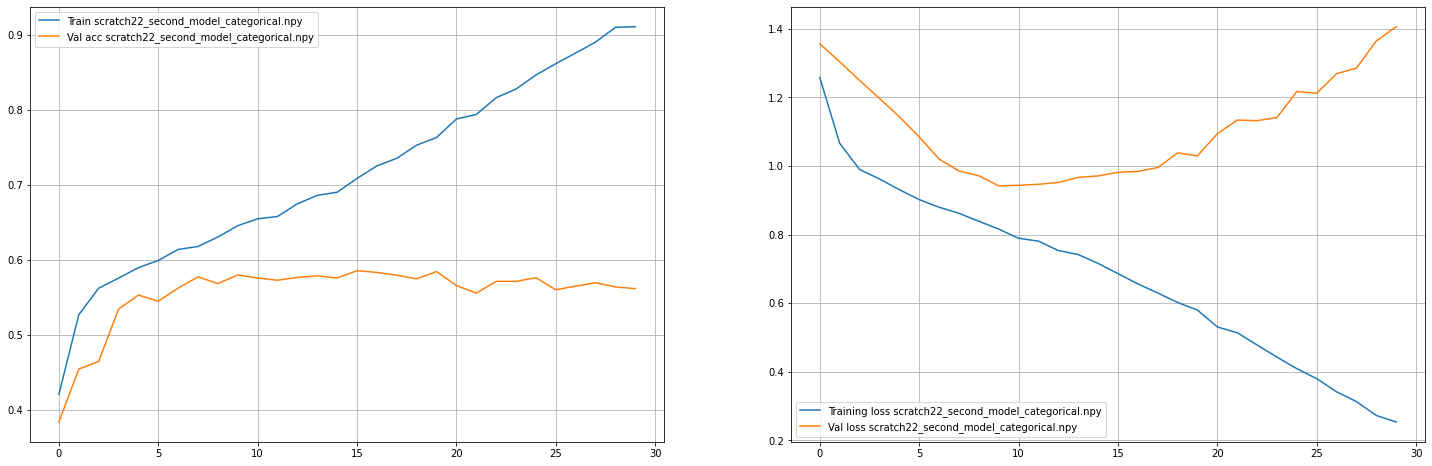

In [ ]:
trainerNtimes(times2run_trainer, genSecondModel_categorical, None, img, labels_train, 
              learning_rate, k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "scratch22_second_model_categorical.npy"))
PlotFiles(("scratch22_second_model_categorical.npy", None))

#Third Model
By modifying the the Second Model Categorical in an AlexNet-alike architecture, it's expetect to see a better performance, because the network is deeper it has more personalise features

In [ ]:
def genThirdModel(arg):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(40, (3, 3), activation='relu', input_shape=(width, height, 1), padding='same', strides=2))
  model.add(layers.BatchNormalization())  
  model.add(layers.MaxPooling2D(2))
  
  model.add(layers.Conv2D(160, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))
  
  model.add(layers.Conv2D(640, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))

  model.add(layers.Conv2D(640*4, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(640*4, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))

  model.add(layers.Conv2D(640, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(160, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))

  model.add(layers.Flatten())
  model.add(layers.Dense(300, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.summary()
  return model  


##Training

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 40)        400       
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 160)       57760     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 640)       922240    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

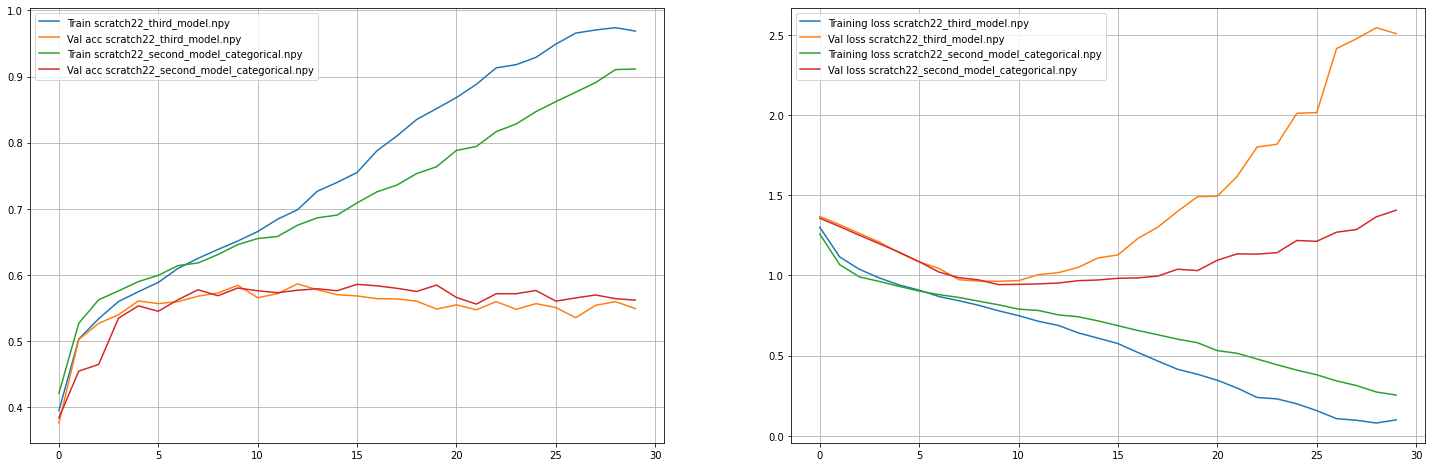

In [ ]:
trainerNtimes(times2run_trainer, genThirdModel, None, img, labels_train, learning_rate, 
              k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "scratch22_third_model.npy"))
PlotFiles(("scratch22_third_model.npy", "scratch22_second_model_categorical.npy"))

The amount of trainable parameters did not increased the accuracy, on the other hand it created over-fitting.

#Fourth Model
Since the two previous model did not performed as expected, another model was built from scratch inspired in the VGG-XX, the Convolutional layers are blocks without losing information (no max-pooling), but between blocks there's MaxPooling layer that summerize the information of the previous block.

In [ ]:
def genFourthModel(arg):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(width, height, 1), padding='same')) 
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  
  # 74x64x64
  model.add(layers.MaxPooling2D(3, strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

  # 36x128x128
  model.add(layers.MaxPooling2D(3, strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

  # 17x256x256
  model.add(layers.MaxPooling2D(3, strides=2))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))

  # 8x512x512
  model.add(layers.MaxPooling2D(3, strides=2))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))

  # 7x512x512
  model.add(layers.MaxPooling2D(3, strides=2))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(4, activation='softmax'))
  model.summary()
  return model    

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 74, 74, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

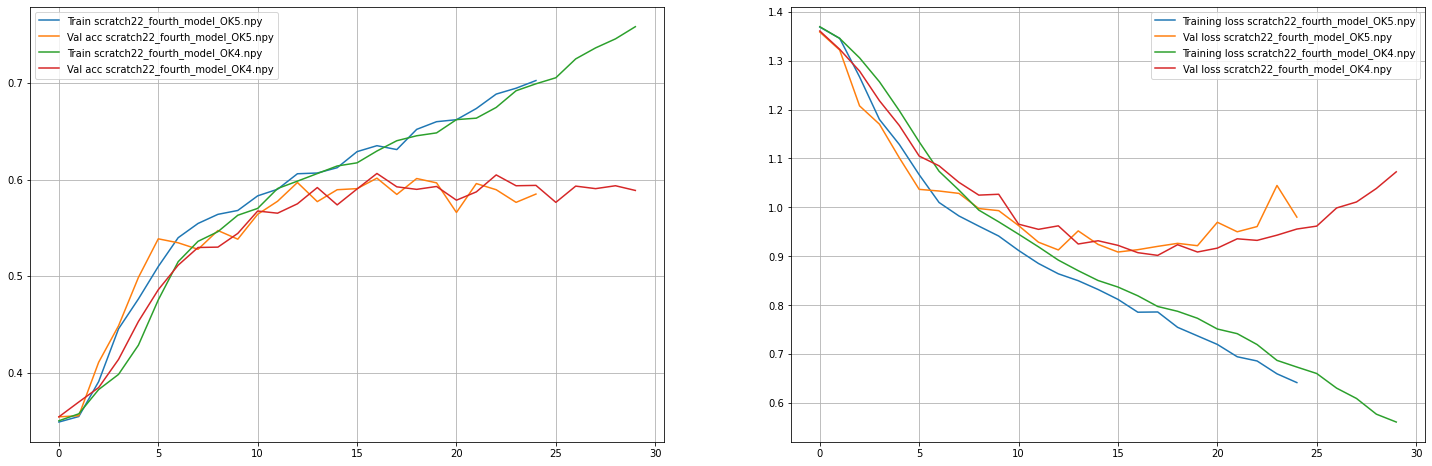

In [ ]:
trainerNtimes(times2run_trainer, genFourthModel, None, img, labels_train, 0.0001, 
              k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "scratch22_fourth_model_OK5.npy"))
PlotFiles(("scratch22_fourth_model_OK5.npy", "scratch22_fourth_model_OK4.npy"))

The accuracy has increased and the loss has decreased in comparison with the Second Model Categorical; however the networks is slow.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

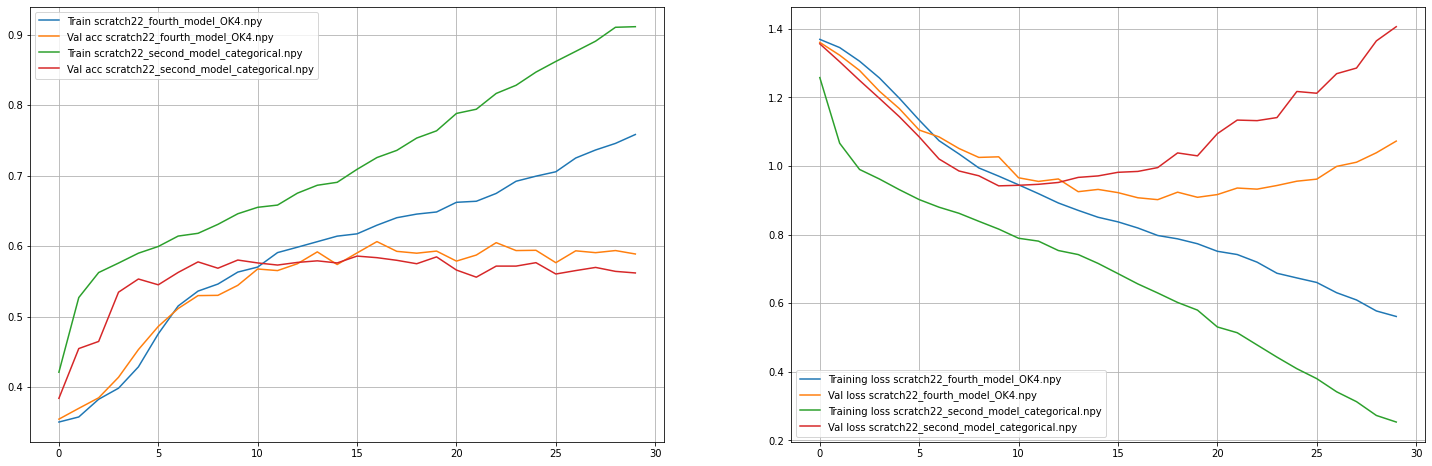

In [ ]:
PlotFiles(("scratch22_fourth_model_OK4.npy", "scratch22_second_model_categorical.npy"))

##Augmented Data
Since, nothing seems to work, neither Batch Normalization or learning rate to make the network faster, the augmented data approaches is proposed in this section. 

[RUNNING@ 0 ] with arg None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

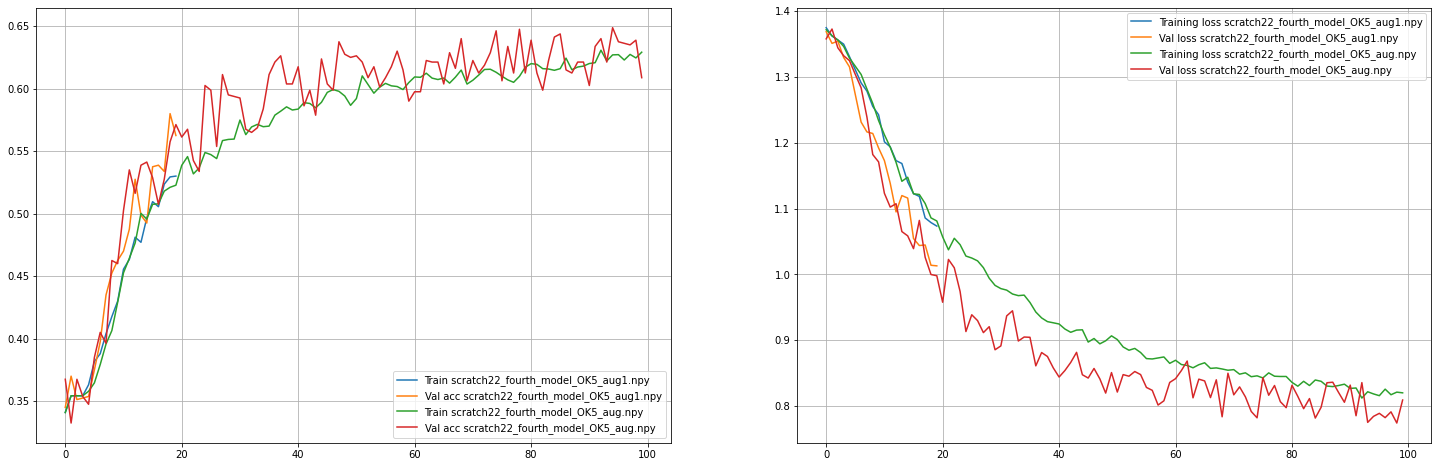

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, genFourthModel, None, img, labels_train, 
                                      0.0005, k, 100, 128, save_model, 
                                      os.path.join(metrics_path, "scratch22_fourth_model_OK5_aug1"))
PlotFiles(("scratch22_fourth_model_OK5_aug1.npy", "scratch22_fourth_model_OK5_aug.npy"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

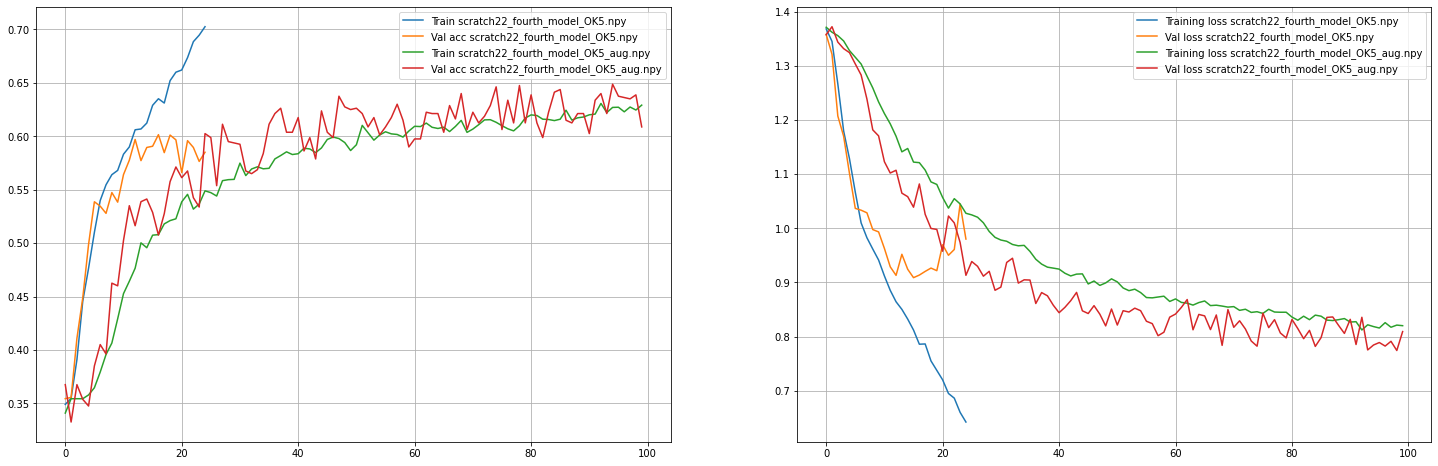

In [ ]:
PlotFiles(("scratch22_fourth_model_OK5.npy", "scratch22_fourth_model_OK5_aug.npy"))

The learning curves above show the networks is extremely slow. Increasing the learning rate makes the network even slower. A long epoch allowed to see that network's long term behavour. In order to understand the network as fast as possible the number of batches have been rised from 32 to 128. Theorically, bigger batches makes network slower, but the networks slow already.

# Ultimate Training
The network is trained with early stopping technique, even the network seems to keep going, the maximum training epoch will be 80.

In [ ]:
def train_only(modelFoo, lr, img, labels_train, epoch, batch_size, weights2load):
  # Compile Model
  model = modelFoo(None)
  adam = Adam(lr=lr)
  
  model.compile(optimizer=adam, loss='categorical_crossentropy')

  # Generator
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     zoom_range=0.2)
  train_generator = train_datagen.flow(img, labels_train, batch_size=batch_size, shuffle=True)

  # Train
  model.fit(train_generator, steps_per_epoch=np.ceil(labels_train.shape[0]/batch_size), 
              epochs=epoch, verbose=1)
  # Save Model
  print('Model Save at:', base_path+weights2load+'_model.h5')
  model.save(base_path+weights2load+'_model.h5')

In [ ]:
train_only(genFourthModel, 0.0005, img, labels_train, 80, 128, "metrics/scratch22_second_model_aug.h5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 150, 150, 64)      640       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 74, 74, 128)       73856     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 74, 74, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 36, 36, 256)      

#Test

##Loading data
Load data for testing purposes

In [ ]:
img_test = np.load(base_path+'dataset/public_test_tensor.npy') 
labels = np.load(base_path+'dataset/public_test_labels.npy') 
depth_test, width_test, height_test = img_test.shape # shape of the train label depth_val, width_val, height_val = images_val.shape # shape of the train label

Processing


the labels of the testing set is hot one enconded.

In [ ]:
labels_test = np.array([]);
idx = [];

# Extracting Abnormalities from data set, and vectorizing the training labels
for i in range(depth_test):

  if (labels[i] == 1):    # Mass, Benign
    idx.append(i)
    labels_test = np.append(labels_test, [1., 0., 0., 0.])

  elif (labels[i] == 2):  # Mass, Malignant
    idx.append(i)
    labels_test = np.append(labels_test, [0., 1., 0., 0.])

  elif (labels[i] == 3):  # Calcification, Benign
    idx.append(i)
    labels_test = np.append(labels_test, [0., 0., 1., 0.])

  elif (labels[i] == 4):  # Calcification, Malignant
    idx.append(i)
    labels_test = np.append(labels_test, [0., 0., 0., 1.])

# Filter abnormalities from full image set
img_test = img_test[idx];
depth_test = idx.__len__()
labels_test = labels_test.reshape(depth_test, 4)

Normalization

In [ ]:
img_test = img_test.reshape((depth_test, width_test, height_test, 1))
img_test = img_test.astype('float32') / 65535;

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(cm, num_classes, labels, title='Confusion matrix', cmap=plt.cm.Greys):
  # plots n = size(cm) confusion matrix in nx2 subplots
  rows = np.ceil(len(cm)/2)
  cm_idx = 1
  cols = 2

  plt.figure(figsize=(15, rows*6))

  for files in cm:
    if files is not None:
      cm_i = np.load(os.path.join(metrics_path, files))
      plt.subplot(rows, cols, cm_idx)
      plt.imshow(cm_i, interpolation='nearest', cmap=cmap)
      plt.title(files)
      plt.colorbar()
      tick_marks = np.arange(num_classes)
      plt.xticks(tick_marks, labels)
      plt.yticks(tick_marks, labels)
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      print(files)
      print("=>", cm_i, "\n")

      cm_idx += 1

  plt.show() 

##Model Under Test

In [ ]:
mut = models.load_model(base_path+'metrics/scratch22_second_model_aug.h5_model.h5')

Prediction

In [ ]:
# test Prediction
y_test = mut.predict(img_test)

# Test Confusion
cmm = confusion_matrix(labels_test.argmax(axis=1), y_test.argmax(axis=1))
cmm = cmm/np.sum(cmm)

# Save Test confusion matrix
np.save(os.path.join(metrics_path, "scratch22_test_cm.npy"), np.stack(cmm))

# Memory release
del mut

print("ACCURACY TEST: ", accuracy_score(labels_test.argmax(axis=1), y_test.argmax(axis=1)))

ACCURACY TEST:  0.5803571428571429


test confusion matrix

precisions per class:

**Benign Mass** = 0.57

**Malignant Mass** = 0.33

**Benign Calcification** = 0.68

**Malignant Calcification** = 0.65

task32_test_control_cm.npy
=> [[0.33630952 0.         0.         0.        ]
 [0.         0.19642857 0.         0.        ]
 [0.         0.         0.31547619 0.        ]
 [0.         0.         0.         0.15178571]] 

scratch22_test_cm.npy
=> [[0.25297619 0.04464286 0.0327381  0.00595238]
 [0.13690476 0.04464286 0.00595238 0.00892857]
 [0.05059524 0.01785714 0.23809524 0.00892857]
 [0.00297619 0.02678571 0.07738095 0.04464286]] 



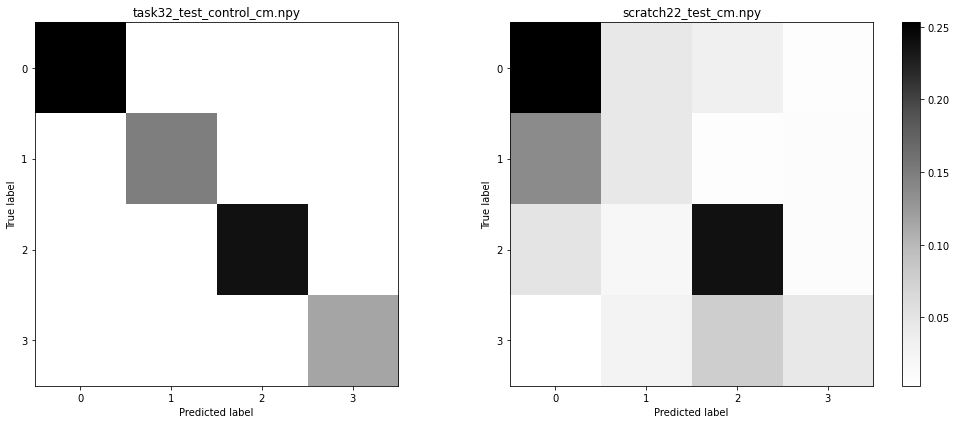

In [ ]:
plot_confusion_matrix(("task32_test_control_cm.npy", "scratch22_test_cm.npy"), 4, [0, 1, 2, 3])